#  Prompt: 

We are looking to build the perfect basketball player. To me, that's Lebron athleticism, Steph’s shooting, Magic Johnson Passing, and Kawhi Leonard defense. Build your perfect player from the last 12 years of players and produce 20 games stat lines (Just PTS, AST, and TRB will do but feel free to add more). Provide visualization to support how this player performed in the 20 games. Again feel free to be creative with your approach. 

# 0 - Introduction

As the prompt states, this hypothetical player needs to be 'Elite' in the following:

- athleticism

- shooting

- passing

- defense

Here is how I will measure those 4 attributes using box score data:

#### Athleticism:

- 2pt FGA

- 2pt FG%

- rebounds

- blocks

- steals

- FTA

Typically athletic players can get to the rim and score with high volume AND accuracy. I do not see another offensive metric that is a competent predictor for sheer athleticism.

Taller/more athletic players are more likely to block shots and grab rebounds.

Quicker/more athletic players are more likely to get steals

Athletic players typically get fouled and go to the line often.

(This one was tougher due to the fact we don't have information on dunks or any events like that in the game that typically only the most athletic players achieve)


#### Shooting:

- 3pt FGA

- 3pt FG %

- FT %

Great shooters have high volume AND high accuracy. 

FT% is also typically a very good predictor of a player's overall shooting ability.

#### Passing:

- assists

- assist to turnover ratio 

Assists is intuitive. 

AST/TO Ratio is not the best way for truly measuring a passer's ability, but the best I can do with box score data.

#### Defense:

- steals

- blocks

This is self explanatory. They are not the best predictors, but these are the only 2 box score metrics that refer to a player's defensive impact.

### How I am going to generate the performance metrics:

Considering our player is elite in all of these aspects, he should be putting up outputs similar to those of the elite's in today's game right now. 

I will 'simulate' these games by using the historical data as a distribution and randomly making draws for each measure. 

I will repeat the following for each measure:

 

1. Grab a subset of the data that represents the game results of players who are elite in that measure ie. for 3P% this subset will consist of players among the likes of Steph Curry, Klay Thompson, Damian Lillard

- Elite = A season in which that player was 95th-99th percentile in that metric on a per game basis. Season is used because we only want the times where that player was elite in the measure, ie. if we were looking at Kobe Bryant's career and the variable of interest is FG Made, I want to sample from a subset that includes the prime seasons where Kobe was elite (Around 10 FGM/game), but not the seasons where he was a rookie/not elite at scoring, or the seasons where he tailed off and was not longer elite at scoring.

2. Generate 20 random draws from this distribution. These will be the simulated box score numbers for the 20 games.

- ie. for 3P FGM, a 99th percentile outcome would be 14 (NBA Record), a 1st percentile outcome would be 0.

- I will use a 90% confidence interval ie. picking values from the 5th percentile box score result up to the 95th

After getting these values for each measure, I will use the results to end up with Pts/Reb/Assists, and more.

Let's get started.

In [484]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import random
import statistics
import warnings
import os
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

# Options
#pd.set_option('max_columns', None)
pd.set_option("display.precision", 3)
warnings.filterwarnings('ignore')

# Read in and view data
google_drive_sharing_url = "https://drive.google.com/file/d/1kWZC9aJf3KCboVfqN8x83kyh6aVSVDWd/view?usp=sharing"
path ='https://drive.google.com/uc?id=' + google_drive_sharing_url.split('/')[-2]
data_full = pd.read_csv(path)
#print(data_full.dtypes)
data_full.head(3)

,uuid,first_name,last_name,canonical,id,season,rk,g,date,age,...,trb,ast,stl,blk,tov,pf,pts,gmsc,plus_minus,full_name
0,c53051d9-767b-4177-921e-3ff8185e68d3,Álex,Abrines,abrinal01,6429,2017-18,53,47,2/2/2018,24-185,...,1,0,0,0,0,3,14,9.1,5,Álex Abrines
1,c53051d9-767b-4177-921e-3ff8185e68d3,Álex,Abrines,abrinal01,6428,2017-18,52,46,2/1/2018,24-184,...,2,1,0,2,1,1,13,10.6,-1,Álex Abrines
2,c53051d9-767b-4177-921e-3ff8185e68d3,Álex,Abrines,abrinal01,6410,2017-18,30,28,12/18/2017,24-139,...,5,0,1,0,0,1,11,12.2,2,Álex Abrines


# 1. Data Wrangling / Cleaning

In [485]:
# Checking NA
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = data.isnull().sum()/data.isnull().count()*100
    percent_final = (np.round(percent, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_final], axis=1, keys=['Total', '%'])
    return missing_data

df = data_full.copy()

df_nan_check = nan_check(data=df)

# Viewing any column that has NA
reqs = (df_nan_check['Total'] != 0)
df_nan_check[reqs]

,Total,%
at,67951,50.8
three_p_pct,26359,19.7
ft_pct,24877,18.6


Here is my process for filling these missing values:

In [486]:
# Function to look at the values of each Column
def table_function(Series):
    value_counts = Series.value_counts(sort=True, ascending=False, dropna=False)
    normalized_value_counts = Series.value_counts(sort=True, ascending=False, dropna=False, normalize=True)
    normalized_value_counts = (np.round(normalized_value_counts, 3))
    join = pd.concat([value_counts, normalized_value_counts], axis=1, keys=['n', 'prop'])
    join = join.reset_index()
    return join

#### Variable: 'at'

In [487]:
table_function(df['at'])

,at,n,prop
0,NaN,67951,0.508
1,@,65880,0.492


@ means that this player's team is on the road.

Therefore, I can derive a new variable and turn NaN's into 'Home' and @'s into 'Away'.

In [488]:
df['home_or_away'] = ['Away' if x == '@' else 'Home' for x in df['at']] 
df.drop(['at'], axis=1, inplace=True)

#### Variables: 'ft_pct', 'three_p_pct', 'fg_pct'

In [489]:
df[['ft', 'fta', 'ft_pct']].sort_values(['fta'], ascending=True).head(1)

,ft,fta,ft_pct
80098,0,0,NaN


In [490]:
df[['three_p', 'three_pa', 'three_p_pct']].sort_values(['three_pa'], ascending=True).head(1)

,three_p,three_pa,three_p_pct
133830,0,0,NaN


In [491]:
df[['fg', 'fga', 'fg_pct']].sort_values(['fga'], ascending=True).head(1)

,fg,fga,fg_pct
31018,1,1,1.0


NaN means that the player shot no free throws/field goals/3pt field goals. 

These columns are OK to leave as NaN for now. Might turn them into 0's later for modeling purposes, if applicable.

#### Variable: mp

In [492]:
df[['mp', 'pts']].sort_values(['pts'], ascending=False).head(5)

,mp,pts
14937,2698,70
4268,2319,62
29171,2187,62
66195,2472,61
52773,36:40:00,61


In [493]:
df[['mp', 'pts']].sort_values(['pts'], ascending=True).head(5)

,mp,pts
133830,1317,10
73048,614,10
16779,1495,10
41714,1662,10
16771,1185,10


I am guessing that this variable is minutes played, but I am not sure what format this data is in.

I am not planning on using this variable for my analysis so I will just move on.

#### Variable: plus_minus

In [494]:
d = table_function(df['plus_minus'])
d

,plus_minus,n,prop
0,3,4382,0.033
1,1,4345,0.032
2,2,4345,0.032
3,5,4326,0.032
4,4,4314,0.032
...,...,...,...
101,52,1,0.000
102,51,1,0.000
103,57,1,0.000
104,-51,1,0.000


In [495]:
d = table_function(df['plus_minus'])

d['plus_minus'] = d['plus_minus'].astype(str)

d.sort_values(['plus_minus'], ascending=False).head(2)

,plus_minus,n,prop
13,9,3774,0.028
12,8,3919,0.029


In [496]:
d = df.copy()

# Fix dtype
d['plus_minus'] = d['plus_minus'].astype(str)

reqs = (d['plus_minus'] == 'nan')
d[reqs][['mp', 'plus_minus', 'fga']].head(3)

,mp,plus_minus,fga


NA in this field appears to be games where the player did not play and/or did not shoot.

Similarly to minutes played, I don't plan on using this column in the analysis so I will leave the NA's as is.

# 2. Simulating from elite seasons for our hypothetical player

In [497]:
def find_elite_player_seasons(df, variable_of_interest, lower_bound, upper_bound):
    """
    Slices a box score dataset to only have elite player seasons games in it.
    
    Parameters
    ----------
    df: pd.DataFrame
        The dataframe that has box score data 
    
    variable_of_interest: str
        The variable we are judging elite on
        
    lower_bound: int
        The lower bound percentile to be used to deem a player's season 'elite'
    
    upper_bound: int
        The upper bound percentile to be used to deem a player's season 'elite'
    
    Outputs
    ----------
    data: pd.DataFrame
        A DataFrame with only the results from the elite players in the statistic 'variable_of_interest'
    """
    ### Grab the subset of elite player seasons for this measure. ###

    # Create an ID that will allow for making a pivot table for each player's individual seasons (ie. 2021-22Trae Young)
    df['id'] = [str(x) + str(y) for x, y in zip(df['season'], df['full_name'])]
    
    # Create pivot table, ranking players by mean value
    pivot_table = df.pivot_table(index='id', values=variable_of_interest, aggfunc=['mean']).reset_index(col_fill=None)
    cols = pivot_table.columns
    pivot_table.columns = [x[0] for x in cols]
    pivot_table.sort_values(['mean'], ascending=False, inplace=True)
    
    # If variable of interest is in the following list, take bottom 5% since a high value is bad ie. Turnovers
    if variable_of_interest in ['tov']:
        upper_bound_value = np.quantile(pivot_table['mean'], (100 - lower_bound)/100)
        lower_bound_value = np.quantile(pivot_table['mean'], (100 - upper_bound)/100)
    else:
        lower_bound_value = np.quantile(pivot_table['mean'], lower_bound/100)
        upper_bound_value = np.quantile(pivot_table['mean'], upper_bound/100)
    
    # Get the set of ID's for elite season (ie. 2021-22Trae Young, 2018-19LebronJames)
    reqs = (pivot_table['mean'] > lower_bound_value) & (pivot_table['mean'] < upper_bound_value) 
    df_elite_subset = pivot_table[reqs]
    set_elite_seasons = set(df_elite_subset['id'])
    
    # Take the subset of the data for elite seasons
    df['keep'] = df['id'].isin(set_elite_seasons)
    reqs = (df['keep'])
    df_subset_elite_box_scores = df[reqs]
    return df_subset_elite_box_scores

In [498]:
def generate_random_outcomes(data, n):
    """
    Parameters
    ------------
    data: list
        A list/array of a probability distribution
    
    n: int
        The number of random draws to generate
        
    Returns
    ------------
    simulated_outcomes
        A list of random outcomes from the probability distribution
    """
    # Get a list stepping from .05, .06, ..., .95
    possible_percentile_values = [x / 100 for x in list(range(5, 95 + 1))]
    
    # Get a list of n random percentile values
    list_random_percentiles = [random.choice(possible_percentile_values) for x in range(20)]
    
    # Remove NA's from the probability distribution
    data_na_removed = [float(x) for x in data if str(x) != 'nan']
    # Retrieve the values/simulated outcomes from the probability distribution that corresponds to this percentile
    simulated_outcomes = [np.quantile(data_na_removed, x) for x in list_random_percentiles]
    return simulated_outcomes

In [499]:
def generate_box_scores(df_box_score_data, variables, lower_bound, upper_bound, n):
    """
    Parameters
    ------------
    df_box_score_data: pd.DataFrame
        Dataframe with the box score dating going back 12 years
    
    variables: list
        A list of variables to generate simulated values from
        
    percentile: int
        A percentile
        
    n: int
        The number of random games to generate
        
    Returns
    ------------
    box score: pd.DataFrame
        A list of random outcomes from the probability distribution
    """
    # Initialize dictionary
    dict_outcomes = {'game': range(1, 20 + 1)}
    
    # For each variable
    for x in variables:
        # Quick fix: for variable 'ft_pct', simply simulate 20 games of 100%!
        if x == "ft_pct":
            l = [1] * 20
            dict_outcomes[x] = l
            continue

        # 1. Slices a box score dataset to only have elite player seasons games in it.
        df_elite_player_seasons = find_elite_player_seasons(df=df_box_score_data,
                                                            variable_of_interest=x,
                                                            lower_bound=lower_bound,
                                                            upper_bound=upper_bound)
        
        # 2.Generate probability distribution
        probability_distribution = df_elite_player_seasons[x]
        # 3. Take 20 random draws
        simulated_outcomes = generate_random_outcomes(data=probability_distribution, n=n)
        # 4. Add this value to the dictionary
        dict_outcomes[x] = simulated_outcomes
        
    # Turn this dictionary into pandas DataFrame
    box_score = pd.DataFrame(dict_outcomes)
    return box_score

# Generate the 20 Game Box Scores

In [500]:
# Derive 2pt FGA / 2pt FGM / 2pt FG%
df['two_p'] = df['fg'] - df['three_p']
df['two_pa'] = df['fga'] - df['three_pa']
df['two_p_pct'] = df['two_p'] / df['two_pa']

In [501]:
# Take the list of variables needed to get our box score stats
list_variables = ['two_pa', 'two_p_pct', 'three_pa', 'three_p_pct', 'fta', 
                  'ft_pct', # leave it in 
                  'orb', 'drb', 'stl', 'blk',
                  'ast', 'tov']

# Generate the raw box score stats
df_raw_box_score = generate_box_scores(df_box_score_data=df, 
                                       variables=list_variables,
                                       lower_bound=95,
                                       upper_bound=100,
                                       n=20)

df_raw_box_score

,game,two_pa,two_p_pct,three_pa,three_p_pct,fta,ft_pct,orb,drb,stl,blk,ast,tov
0,1,18.0,1.000,11.0,1.000,4.0,1,6.00,9.0,1.0,4.0,6.0,0.0
1,2,22.0,0.857,9.0,0.800,9.0,1,6.00,10.0,1.0,3.0,7.0,0.0
2,3,18.0,1.000,5.0,1.000,9.0,1,4.00,9.0,4.0,4.0,6.0,1.0
3,4,11.0,0.667,6.0,0.500,10.0,1,3.00,7.0,2.0,3.0,8.0,0.0
4,5,14.0,0.889,9.0,0.667,6.0,1,3.00,7.0,2.0,2.0,10.0,0.0
5,6,15.0,1.000,7.0,1.000,7.0,1,3.00,13.0,1.0,1.0,5.0,0.0
6,7,12.0,0.857,8.0,0.750,6.0,1,1.00,7.0,1.0,3.0,6.0,0.0
7,8,17.0,1.000,7.0,1.000,2.0,1,3.00,10.0,2.0,2.0,5.0,0.0
8,9,22.0,0.833,12.0,1.000,5.0,1,3.00,5.0,1.0,4.0,9.0,0.0
9,10,19.0,0.667,8.0,1.000,11.0,1,8.00,10.0,0.0,3.0,8.0,0.0


# Data Viz

## Tables

In [502]:
### Set working environment for saving viz's
directory = os.getcwd()

# If path doesn't exist, create it
if not os.path.exists(directory + "\data-viz"):
    os.mkdir(directory + "\data-viz")

In [503]:
def color_negative_red(value):
    """
    Colors elements in a dateframe green if above the threshold and red if negative. Does not color NaN values.
    
    Parameters
    ----------
    value: int 
        The number in the dataframe
        
    Returns 
    ----------
    message: str
        The color that the number will become
        
    """
    if value < 40:
        color = 'red'
    elif value >= 40:
        color = 'green'
    else:
        color = 'black'

    return f'color: {color}'

In [504]:
def create_output_table(data, full):
    """
    Derives the variables to have in the DataFrame table output.
    
    Parameters
    ----------
    data: pd.DataFrame
        The dataframe with results from the 20 games
        
    full: boolean
        Whether or not to create the full table, or just PTS/REB/AST
        
    Returns
    ----------
    answer: pd.DataFrame
        The color coded dataframe
    """
    df = data
    
    df['2P Att.'] = df['two_pa']
    df['3P Att.'] = df['three_pa']
    df['FT Att.'] = df['fta']
    df['2P Made'] = df['two_pa'] * df['two_p_pct']
    df['3P Made'] = df['three_pa'] * df['three_p_pct']
    df['FT Made'] = df['fta'] * df['ft_pct']
    
    df['FG Made'] = df['2P Made'] + df['3P Made']
    df['FG Att.'] = df['2P Att.'] + df['3P Att.']
    df['FG%'] = (df['2P Made'] + df['3P Made']) / (df['2P Att.'] + df['3P Att.'])
    df['2P%'] = df['two_p_pct']
    df['3P%'] = df['three_p_pct']
    df['FT%'] = df['ft_pct']
    
    df['Points'] = (2 * df['2P Made']) + (3 * df['3P Made']) + (1 * df['FT Made'])
    df['Rebounds'] = df['orb'] + df['drb']
    df['Assists'] = df['ast']
    df['Steals'] =  df['stl']
    df['Blocks'] =  df['blk']
    
    df['Turnovers'] = df['tov']
    df['Assist/TO Ratio'] = df['Assists'] / df['Turnovers']
    
    answer = df.loc[: , 'Points': 'Assists'].copy()
    
    if full:
        answer = df[['Points', 'Rebounds', 'Assists', 'Steals', 'Blocks', 
                     'FG Made', 'FG Att.', 'FG%',
                     '2P Made', '2P Att.', '2P%',
                     '3P Made', '3P Att.', '3P%',
                     'FT Made', 'FT Att.', 'FT%',
                     'Turnovers', 'Assist/TO Ratio'
                    ]]
        
        answer['FG Made'] = round(answer['FG Made'], 0)
        answer['2P Made'] = round(answer['2P Made'], 0)
        answer['3P Made'] = round(answer['3P Made'], 0)
        answer['FT Made'] = round(answer['FT Made'], 0)
        
    
    answer['Points'] = round(answer['Points'], 0)
    return answer

# Answer with Just PTS/REB/AST:

In [505]:
def create_plotly_table(data, name, title):
    """
    Turns data into a neat plotly table.
    
    Parameters
    ----------
    data: pd.DataFrame
        The box score data
        
    name: str
        The name for the eventual .png file
        
    title: str
        Title for the plot
        
    Parameters
    ----------
    fig: plotly Figure
        The table output
    """
    headerColor = 'black'
    rowEvenColor = 'lightgrey'
    rowOddColor = 'white'
    
    fig = go.Figure(data=[go.Table(
    
    columnorder = [1, 2, 3],
    columnwidth = [20]*3,
    
    header=dict(values=list(data.columns),
                line_color='darkslategray',
                fill_color=headerColor,
                align=['left','center'],
                font=dict(color='white', size=12)),
    
    cells=dict(values=[col_data for (col_name, col_data) in data.items()],
               fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor, rowEvenColor]*50],
                align = ['left', 'center'],
                font = dict(color = 'darkslategray', size = 10)
              )
    )])
    
    if name == 'full_output':
        fig = go.Figure(data=[go.Table(
    
        columnorder = list(range(1, 20)),
        columnwidth = [50]*19,

        header=dict(values=list(data.columns),
                    line_color='darkslategray',
                    fill_color=headerColor,
                    align=['left','center'],
                    font=dict(color='white', size=12)),

        cells=dict(values=[col_data for (col_name, col_data) in data.items()],
                   fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor, rowEvenColor]*50],
                    align = ['left', 'center'],
                    font = dict(color = 'darkslategray', size = 10)
                  )
        )])
        

    # Save
    fig.update_layout(
        margin=dict(l=0,r=0,b=0,t=0),
        autosize=False,
        width=1000,
        height=1600,)
    
    fig.update_layout(title_text=title)
    return fig.show()

In [506]:
data = create_output_table(data=df_raw_box_score, full=False)

create_plotly_table(data=data, name='condensed_output', title='Points, Rebounds, and Assists from 20 Games')

# Table with more measures:

In [507]:
data = create_output_table(data=df_raw_box_score, full=True)

for col_name, col_values in data.items():
    if col_name in ['FG%', '2P%', '3P%', 'FT%']:
        data[col_name] = col_values * 100
        data[col_name] = data[col_name].map('{:,.1f}%'.format)
    else:
        data[col_name] = data[col_name].map('{:,.0f}'.format)

create_plotly_table(data=data, name='full_output', title='All Box Score Statistics from 20 Games')

## Graphs

In [508]:
def create_line_plot(data, data_elite, var, var_name_new, y_axis_range):
    """
    Creates a line plot for the given variable.
    
    Parameters
    ----------
    data: pd.DataFrame
        The results from 20 games of simulated games
        
    data_elite: pd.DataFrame
        A dataframe with only the observations coming from elite players, for this measure
        
    var: str
        The name of the string in data
        
    var_new_name: str
        The tidy version of the name of the string in data
        
    y_axis_range: tuple of int or tuple of float
        A tuple with the min and max value for the graph
    
    Returns 
    ----------
    plot: matplotlib
        The line graph
    """
    # Change the variable name to the better one
    data_elite[var_name_new] = data_elite[var]
    
    # Add 'Game' to the output 
    data['Game'] = range(1, 21)
    
    # Create plot
    plt.plot(data['Game'], data[var_name_new], 'green')
    
    # Add labels to plot, set y-axis
    plt.suptitle(f'{var_name_new}\n(over 20 games, compared to mean for an elite player.)',
                fontsize=15)
    plt.xlabel('Game #')
    plt.ylabel(var_name_new)
    plt.ylim([y_axis_range[0], y_axis_range[1]])
    
    # Add horizontal line for mean value
    elite_mean = statistics.mean(data_elite[var_name_new])
    plt.axhline(y=elite_mean,
                color='r', 
                linestyle='-')
    
    # Make axises look better
    plt.xticks(np.arange(1, 20+1, step=1))
    
    # Save
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.tight_layout()
    
    plt.savefig(f"data-viz/{var_name_new}.png", dpi=800, bbox_inches='tight')
    return plt.show()

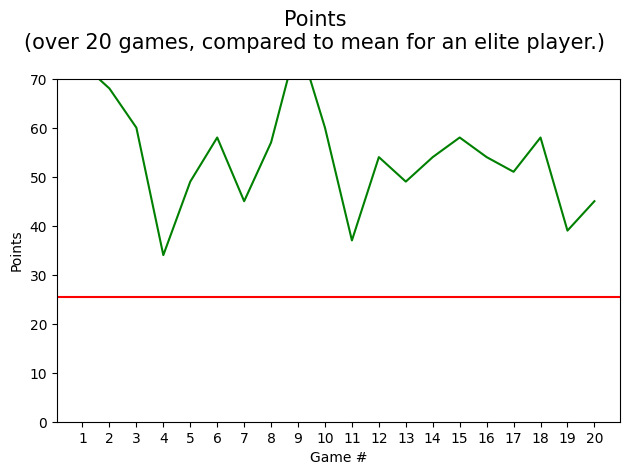

In [509]:
var_name_old='pts'
var_name_new='Points'
create_line_plot(data=create_output_table(data=df_raw_box_score, full=True),
                 data_elite=find_elite_player_seasons(df=df, variable_of_interest=var_name_old, lower_bound=95, upper_bound=100), 
                 var=var_name_old, 
                 var_name_new=var_name_new, 
                 y_axis_range=(0, 70))

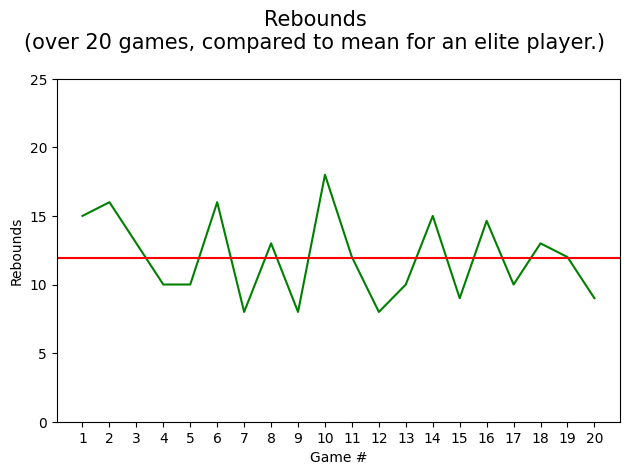

In [510]:
var_name_old='trb'
var_name_new='Rebounds'
create_line_plot(data=create_output_table(data=df_raw_box_score, full=True),
                 data_elite=find_elite_player_seasons(df=df, variable_of_interest=var_name_old, lower_bound=95, upper_bound=100), 
                 var=var_name_old, 
                 var_name_new=var_name_new, 
                 y_axis_range=(0, 25))

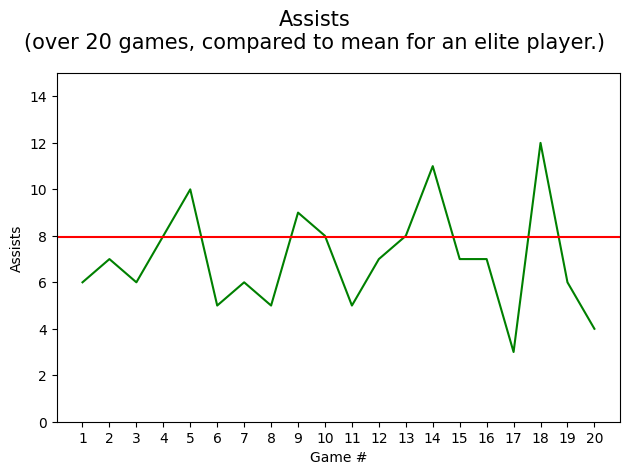

In [511]:
var_name_old='ast'
var_name_new='Assists'
create_line_plot(data=create_output_table(data=df_raw_box_score, full=True),
                 data_elite=find_elite_player_seasons(df=df, variable_of_interest=var_name_old, lower_bound=95, upper_bound=100), 
                 var=var_name_old, 
                 var_name_new=var_name_new, 
                 y_axis_range=(0, 15))

In [512]:
def create_grouped_bar_graph(df_simulated_box_scores, data):
    """
    Creates a bar plot for comparing each variable - 20 Games output vs Elite's mean.
    
    Parameters
    ----------
    df_simulated_box_scores: pd.DataFrame
        The results from 20 games of simulated games
        
    data: pd.DataFrame
        A dataframe with all box score data 
    
    Returns 
    ----------
    plot: matplotlib
        The bar graph
    """
    name_mapper = {
               "tidy": {"pts" : 'Points',
                        "trb": 'Rebounds',
                        "ast": 'Assists',
                        "stl": 'Steals',
                        "blk": 'Blocks',
                        "fg": 'FG Made',
                        "fga": 'FG Att.',
                        "fg_pct": 'FG%',
                        "three_p": '3P Made',
                        "three_pa": '3P Att.',
                        "three_p_pct": '3P%',
                        "ft": 'FT Made',
                        "fta": 'FT Att.',
                        "ft_pct": 'FT%',
                        "tov": 'Turnovers', 
                         }}
    
    # Initialize Plot Data
    plot_data = {
        'Hypothetical Player': {},
        'Elite Players': {}
    }

    #### Run function to get values for player's 20 games ####
    player_data = create_output_table(data=df_simulated_box_scores, full=True)

    # Drop columns that are not in the box score data
    player_data.drop(['2P Made', '2P Att.', '2P%', 'Assist/TO Ratio'], axis=1, inplace=True)

    # Loop over and add to plot_data
    for (col_name, col_data) in player_data.items():
        mean_value = statistics.mean(col_data)
        plot_data['Hypothetical Player'][col_name] = mean_value


    #### Loop over variables to get mean values ####
    variables = list(plot_data['Hypothetical Player'].keys())
    
    for col_name in variables:
        # 0. Quick fix for FT%
        if col_name == "FT%":
            plot_data['Elite Players'][col_name] = 1
            continue
        # 1. Slices a box score dataset to only have elite player seasons games in it.
        df_elite_player_seasons = find_elite_player_seasons(df=data.rename(columns=name_mapper['tidy']),
                                                            variable_of_interest=col_name,
                                                            lower_bound=95,
                                                            upper_bound=100)

        # 2. Remove NA values from the column of interest
        column_values_no_nas = [float(x) for x in df_elite_player_seasons[col_name] if str(x) != 'nan']

        # 3. Grabs mean value from this elite group
        mean_value = statistics.mean(column_values_no_nas)

        # 4. appends to plot data
        plot_data['Elite Players'][col_name] = mean_value

    #### Create plot ####
    
    # Get data into dataframe
    df_plot_data = pd.DataFrame(plot_data).reset_index()

    # Go from wide format to long format
    list_of_id_vars = ['Hypothetical Player', 'Elite Players']
    opposites_list = [x for x in df_plot_data.columns if x not in list_of_id_vars]
    df_long_format = df_plot_data.melt(id_vars=opposites_list)
    
    # Plot
    g = sns.catplot(
        data=df_long_format, 
        kind="bar",
        x="value", 
        y="index", 
        hue="variable",
        ci="sd", 
        palette="tab10", 
        alpha=.6, 
        height=6
    )

    g.despine(left=True, bottom=True)
    g.set_axis_labels("Value", "Box Score Statistic")
    g.legend.set_title("Legend")
    g.set(title='Comparing Measures \nBetween hypothetical player and Elite Group (95-99%)')
    
    # Save
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.tight_layout()
    plt.savefig(f'data-viz/GroupedBarGraph.png', dpi=800, bbox_inches='tight')
    return plt.show()

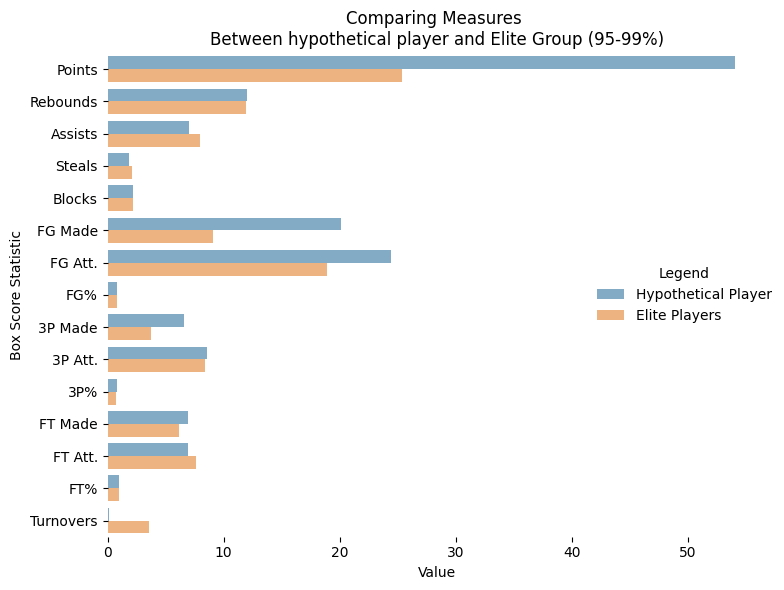

In [513]:
plot = create_grouped_bar_graph(df_simulated_box_scores=df_raw_box_score,
                         data=df
                        )
plot

In [514]:
print("Done!")

Done!
